In [1]:
import sys
sys.path.append("/remote/gpu03/schiller/JetCalibration")

import torch
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy
import os

from Source.plots import compute_range, figs_hist1d, figs_hist_twice
from Source.plots import colors as atlas_colors

2025-08-07 11:36:19.513126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754559379.533232 1377761 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754559379.539351 1377761 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754559379.555248 1377761 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754559379.555265 1377761 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754559379.555267 1377761 computation_placer.cc:177] computation placer alr

# Classifier weights

## Different networks

In [2]:
paths = [
    "/remote/gpu03/schiller/JetCalibration/results/20250707_144305_GMM_test4",
    "/remote/gpu03/schiller/JetCalibration/results/20250716_225717_Multivariate_GMM2",
    "/remote/gpu03/schiller/JetCalibration/results/20250709_165533_CFM3"
]
network_names = [
    "univar. GMM",
    "multivar. GMM",
    "CFM"
]
colors = [
    atlas_colors["bk"],
    atlas_colors["bl"],
    atlas_colors["gn"]
]

In [3]:
weights_paths = [os.path.join(path, "classifier", "Jet_MC_FullPhaseSpace", "weights.pt") for path in paths]

In [4]:
weights = []
for weights_path in weights_paths:
    weights.append(torch.load(weights_path, map_location="cpu", weights_only=True))
    print(f"File {weights_path} loaded")

File /remote/gpu03/schiller/JetCalibration/results/20250707_144305_GMM_test4/classifier/Jet_MC_FullPhaseSpace/weights.pt loaded
File /remote/gpu03/schiller/JetCalibration/results/20250716_225717_Multivariate_GMM2/classifier/Jet_MC_FullPhaseSpace/weights.pt loaded
File /remote/gpu03/schiller/JetCalibration/results/20250709_165533_CFM3/classifier/Jet_MC_FullPhaseSpace/weights.pt loaded


In [5]:
for path, weight in zip(weights_paths, weights):
    classes = weight["class"]
    print(f"{path}:")
    print(f"classes: {classes.shape}")
    print(f"classes 0: {classes[classes == 0].shape}")
    print(f"classes 1: {classes[classes == 1].shape}")
    print(f"Diff: {classes.shape[0] - classes[classes == 0].shape[0] - classes[classes == 1].shape[0]}")
    print()

/remote/gpu03/schiller/JetCalibration/results/20250707_144305_GMM_test4/classifier/Jet_MC_FullPhaseSpace/weights.pt:
classes: torch.Size([983792448, 1])
classes 0: torch.Size([964502400])
classes 1: torch.Size([19290048])
Diff: 0

/remote/gpu03/schiller/JetCalibration/results/20250716_225717_Multivariate_GMM2/classifier/Jet_MC_FullPhaseSpace/weights.pt:
classes: torch.Size([149079732, 1])
classes 0: torch.Size([146156600])
classes 1: torch.Size([2923132])
Diff: 0

/remote/gpu03/schiller/JetCalibration/results/20250709_165533_CFM3/classifier/Jet_MC_FullPhaseSpace/weights.pt:
classes: torch.Size([149079732, 1])
classes 0: torch.Size([146156600])
classes 1: torch.Size([2923132])
Diff: 0



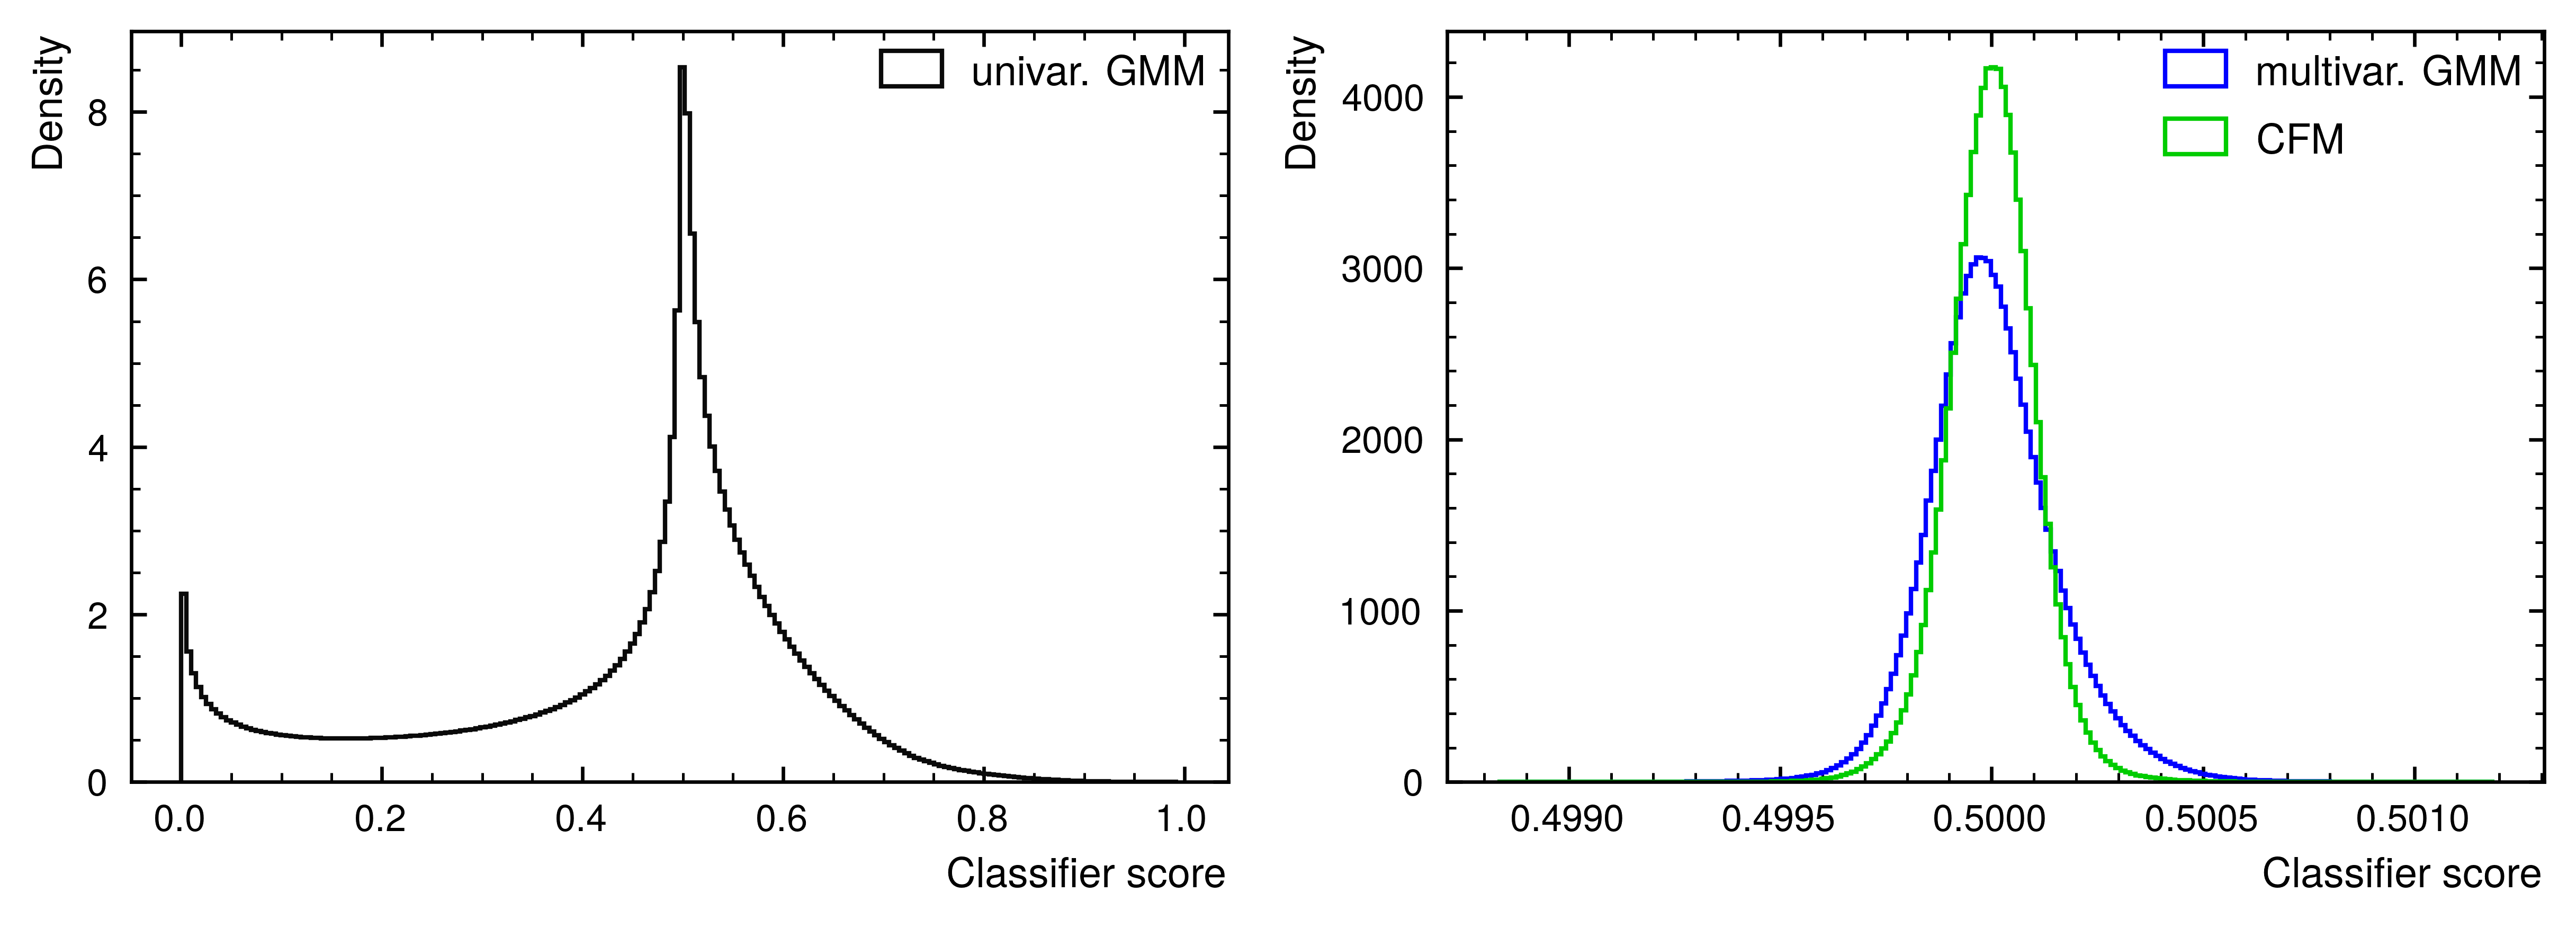

In [6]:
with PdfPages(os.path.join("/remote/gpu03/schiller/JetCalibration/results/compare_runs", "classifier_scores.pdf")) as pdf:
        legend_objs = []
        legend_labels = []

        nbins = 200

        # pred_range = compute_range([weight["weight"] for weight in weights], quantile=0.00001)
        pred_range = compute_range([weight["weight"] for weight in weights[:1]], quantile=0.00001)

        fig1, axs = plt.subplots(1, 2, figsize=figs_hist_twice)
        for i, (weight, label, color) in enumerate(zip(weights[:1], network_names[:1], colors[:1])):
                classes = weight["class"]
                scores = weight["weight"][classes == 0]
                _, _, h = axs[0].hist(scores, bins=nbins, range=pred_range, density=True, histtype='step', color=color)
                
                legend_objs.append(h[0])
                legend_labels.append(label)
        axs[0].set_xlabel("Classifier score", fontsize=11)
        axs[0].set_ylabel('Density', fontsize=11)
        # axs[0].set_yscale('log')
        axs[0].tick_params(axis='both', which='major', labelsize=10)
        
        pred_range = compute_range([weight["weight"] for weight in weights[1:]], quantile=0.00001)

        for weight, label, color in zip(weights[1:], network_names[1:], colors[1:]):
                classes = weight["class"]
                scores = weight["weight"][classes == 0]
                _, _, h = axs[1].hist(scores, bins=nbins, range=pred_range, density=True, histtype='step', color=color)

                legend_objs.append(h[0])
                legend_labels.append(label)
        axs[1].set_xlabel("Classifier score", fontsize=11)
        axs[1].set_ylabel('Density', fontsize=11)
        axs[1].tick_params(axis='both', which='major', labelsize=10)

        # fig1.legend(legend_objs, legend_labels, ncol=3, loc='upper left', bbox_to_anchor=(0.5, 0.95), framealpha=0.)
        # fig1.subplots_adjust(top=0.85)
        axs[0].legend(legend_objs[:1], legend_labels[:1])
        axs[1].legend(legend_objs[1:], legend_labels[1:])

        plt.tight_layout()
        pdf.savefig(fig1)

        # nbins = 200

        # pred_range = compute_range([weight["weight"] for weight in weights], quantile=0.00001)
        # fig2, axs = plt.subplots(1, 2, figsize=figs_hist1d)
        # for weight, label in zip(weights, network_names):
        #         classes = weight["class"]
        #         scores = weight["weight"][classes == 0]
        #         axs[0].hist(scores, bins=nbins, range=pred_range, density=True, histtype='step', label=label)
        # axs[0].legend()
        # axs[0].set_xlabel("Classifier score")
        # axs[0].set_ylabel('Density')
        # axs[0].set_yscale('log')

        # pred_range = compute_range([weight["weight"] for weight in weights[1:]], quantile=0.00001)

        # for weight, label in zip(weights[1:], network_names[1:]):
        #         classes = weight["class"]
        #         scores = weight["weight"][classes == 0]
        #         axs[1].hist(scores, bins=nbins, range=pred_range, density=True, histtype='step', label=label)
        # axs[1].legend()
        # axs[1].set_xlabel("Classifier score")
        # axs[1].set_ylabel('Density')
        # axs[1].set_yscale('log')

        # plt.tight_layout()
        # pdf.savefig(fig2)

        plt.show()

        plt.close(fig1)
        # plt.close(fig2)

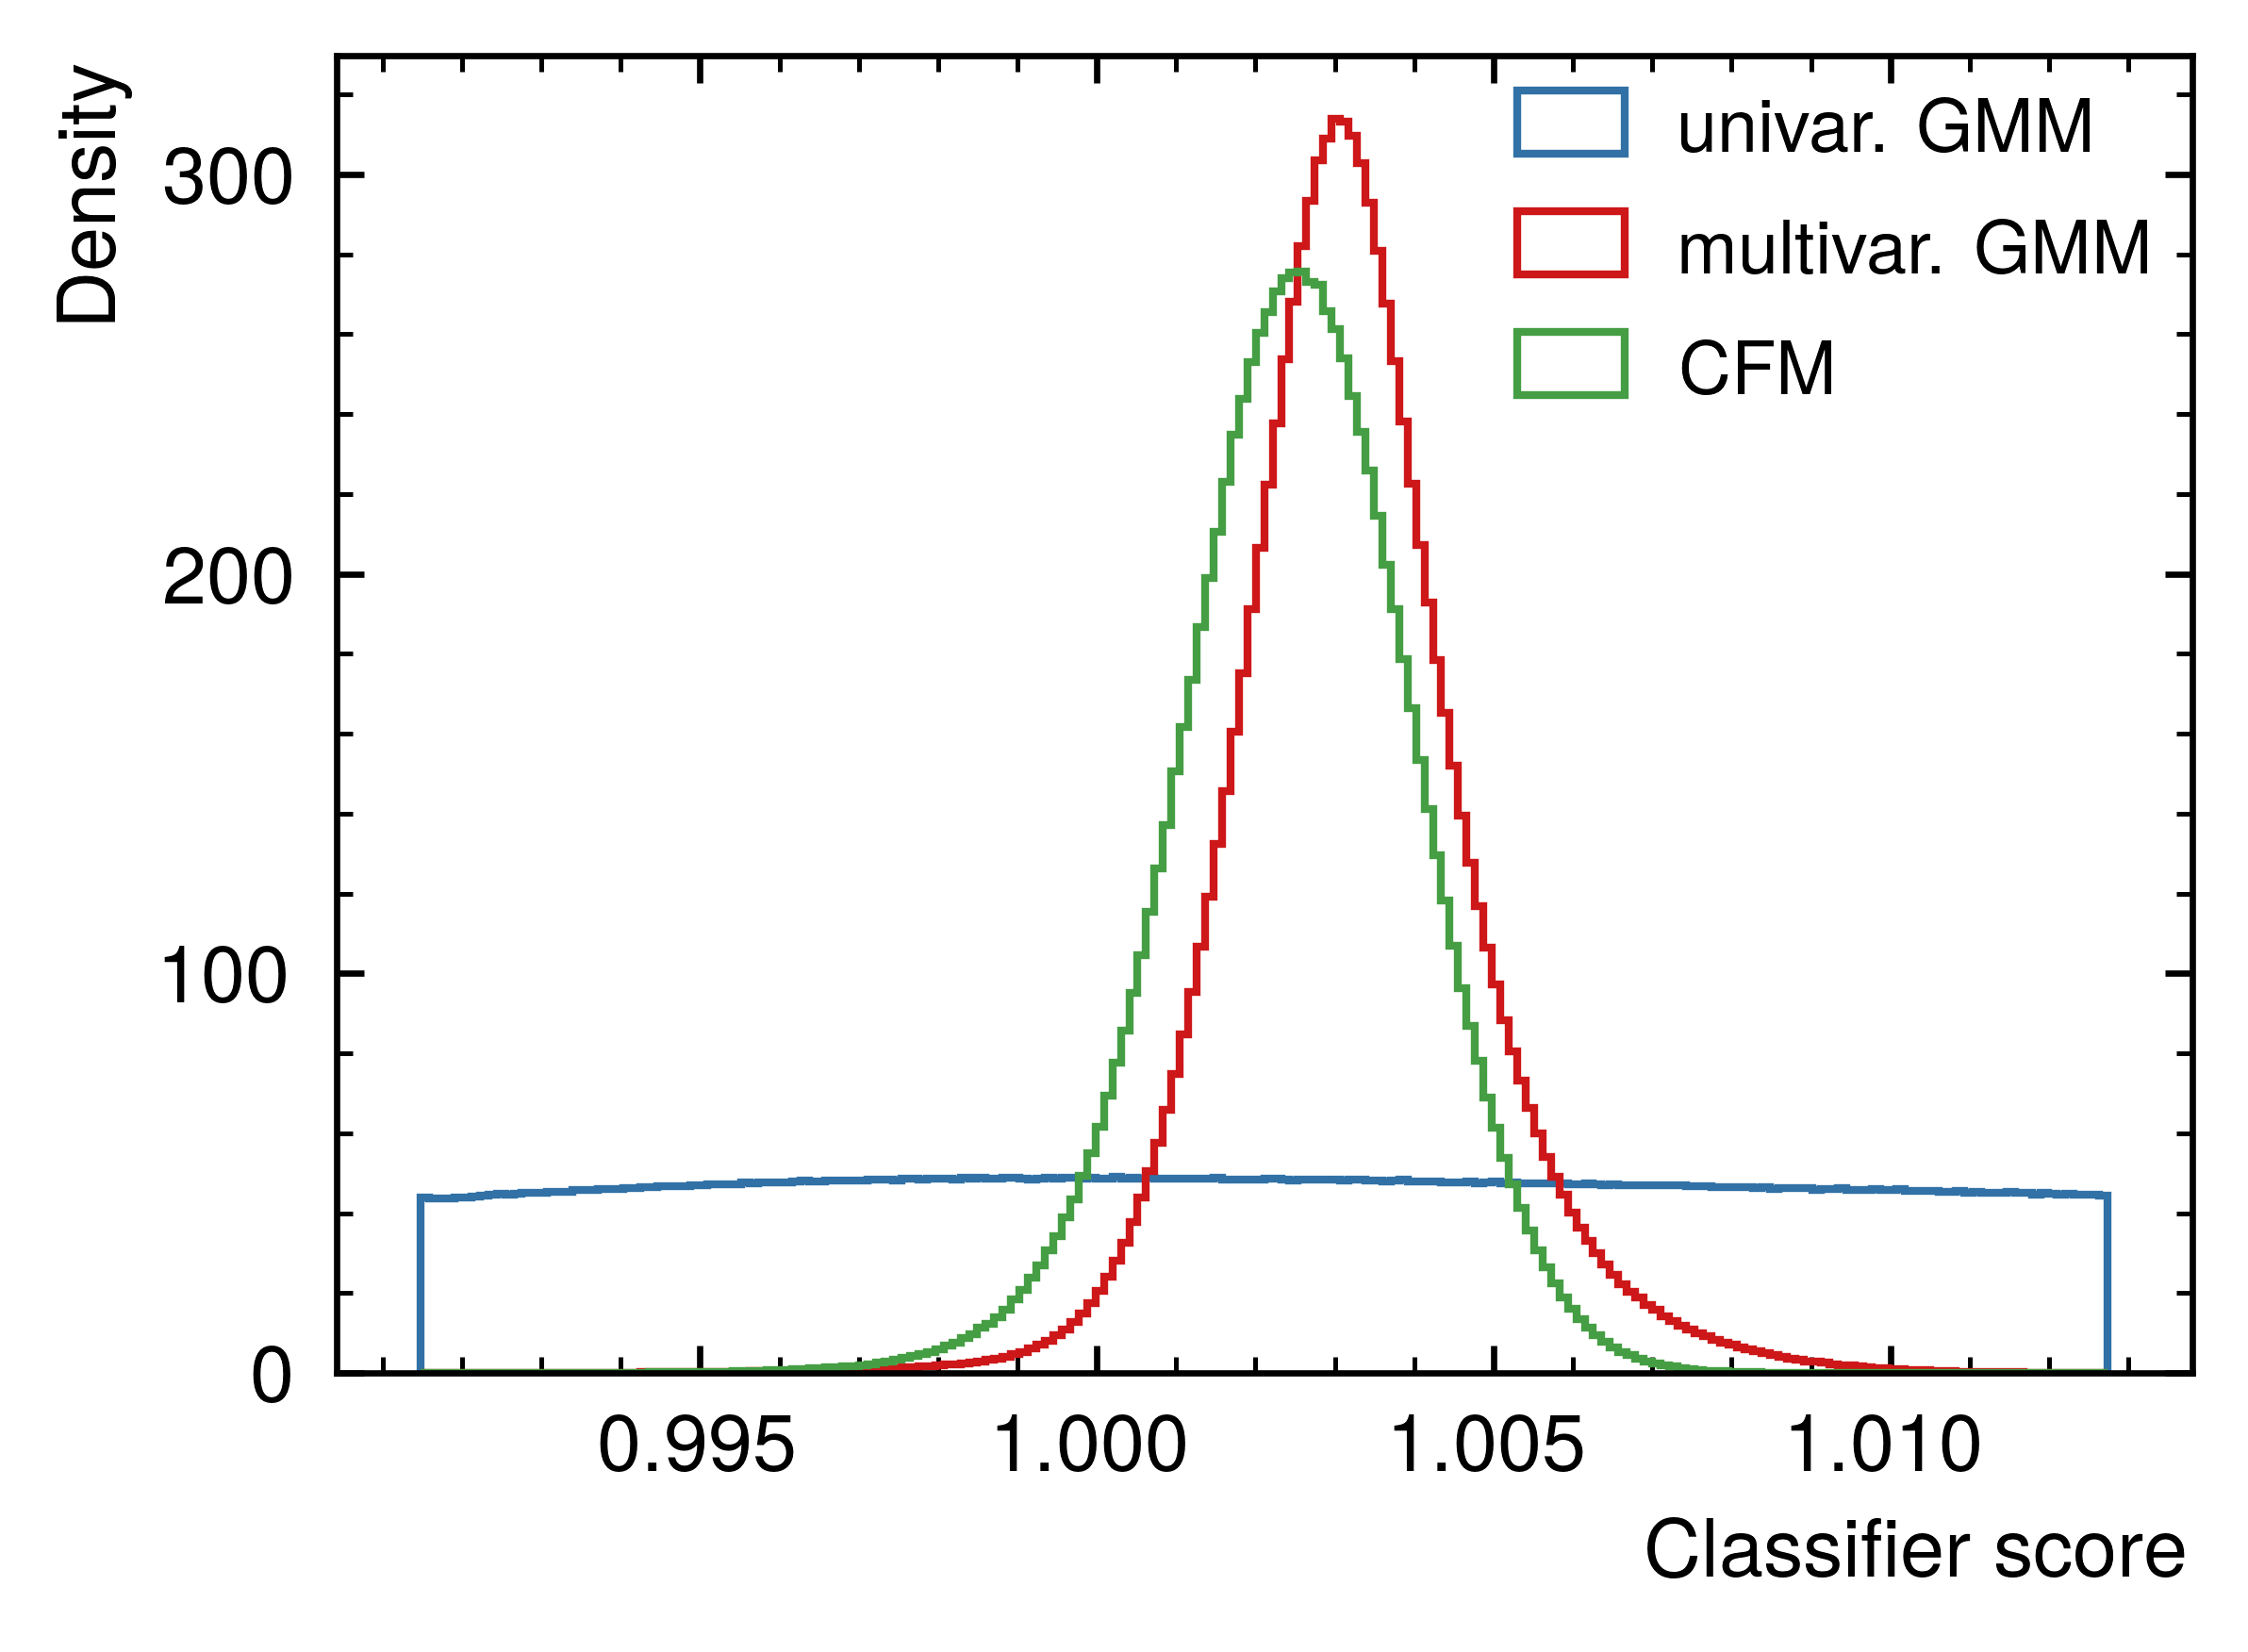

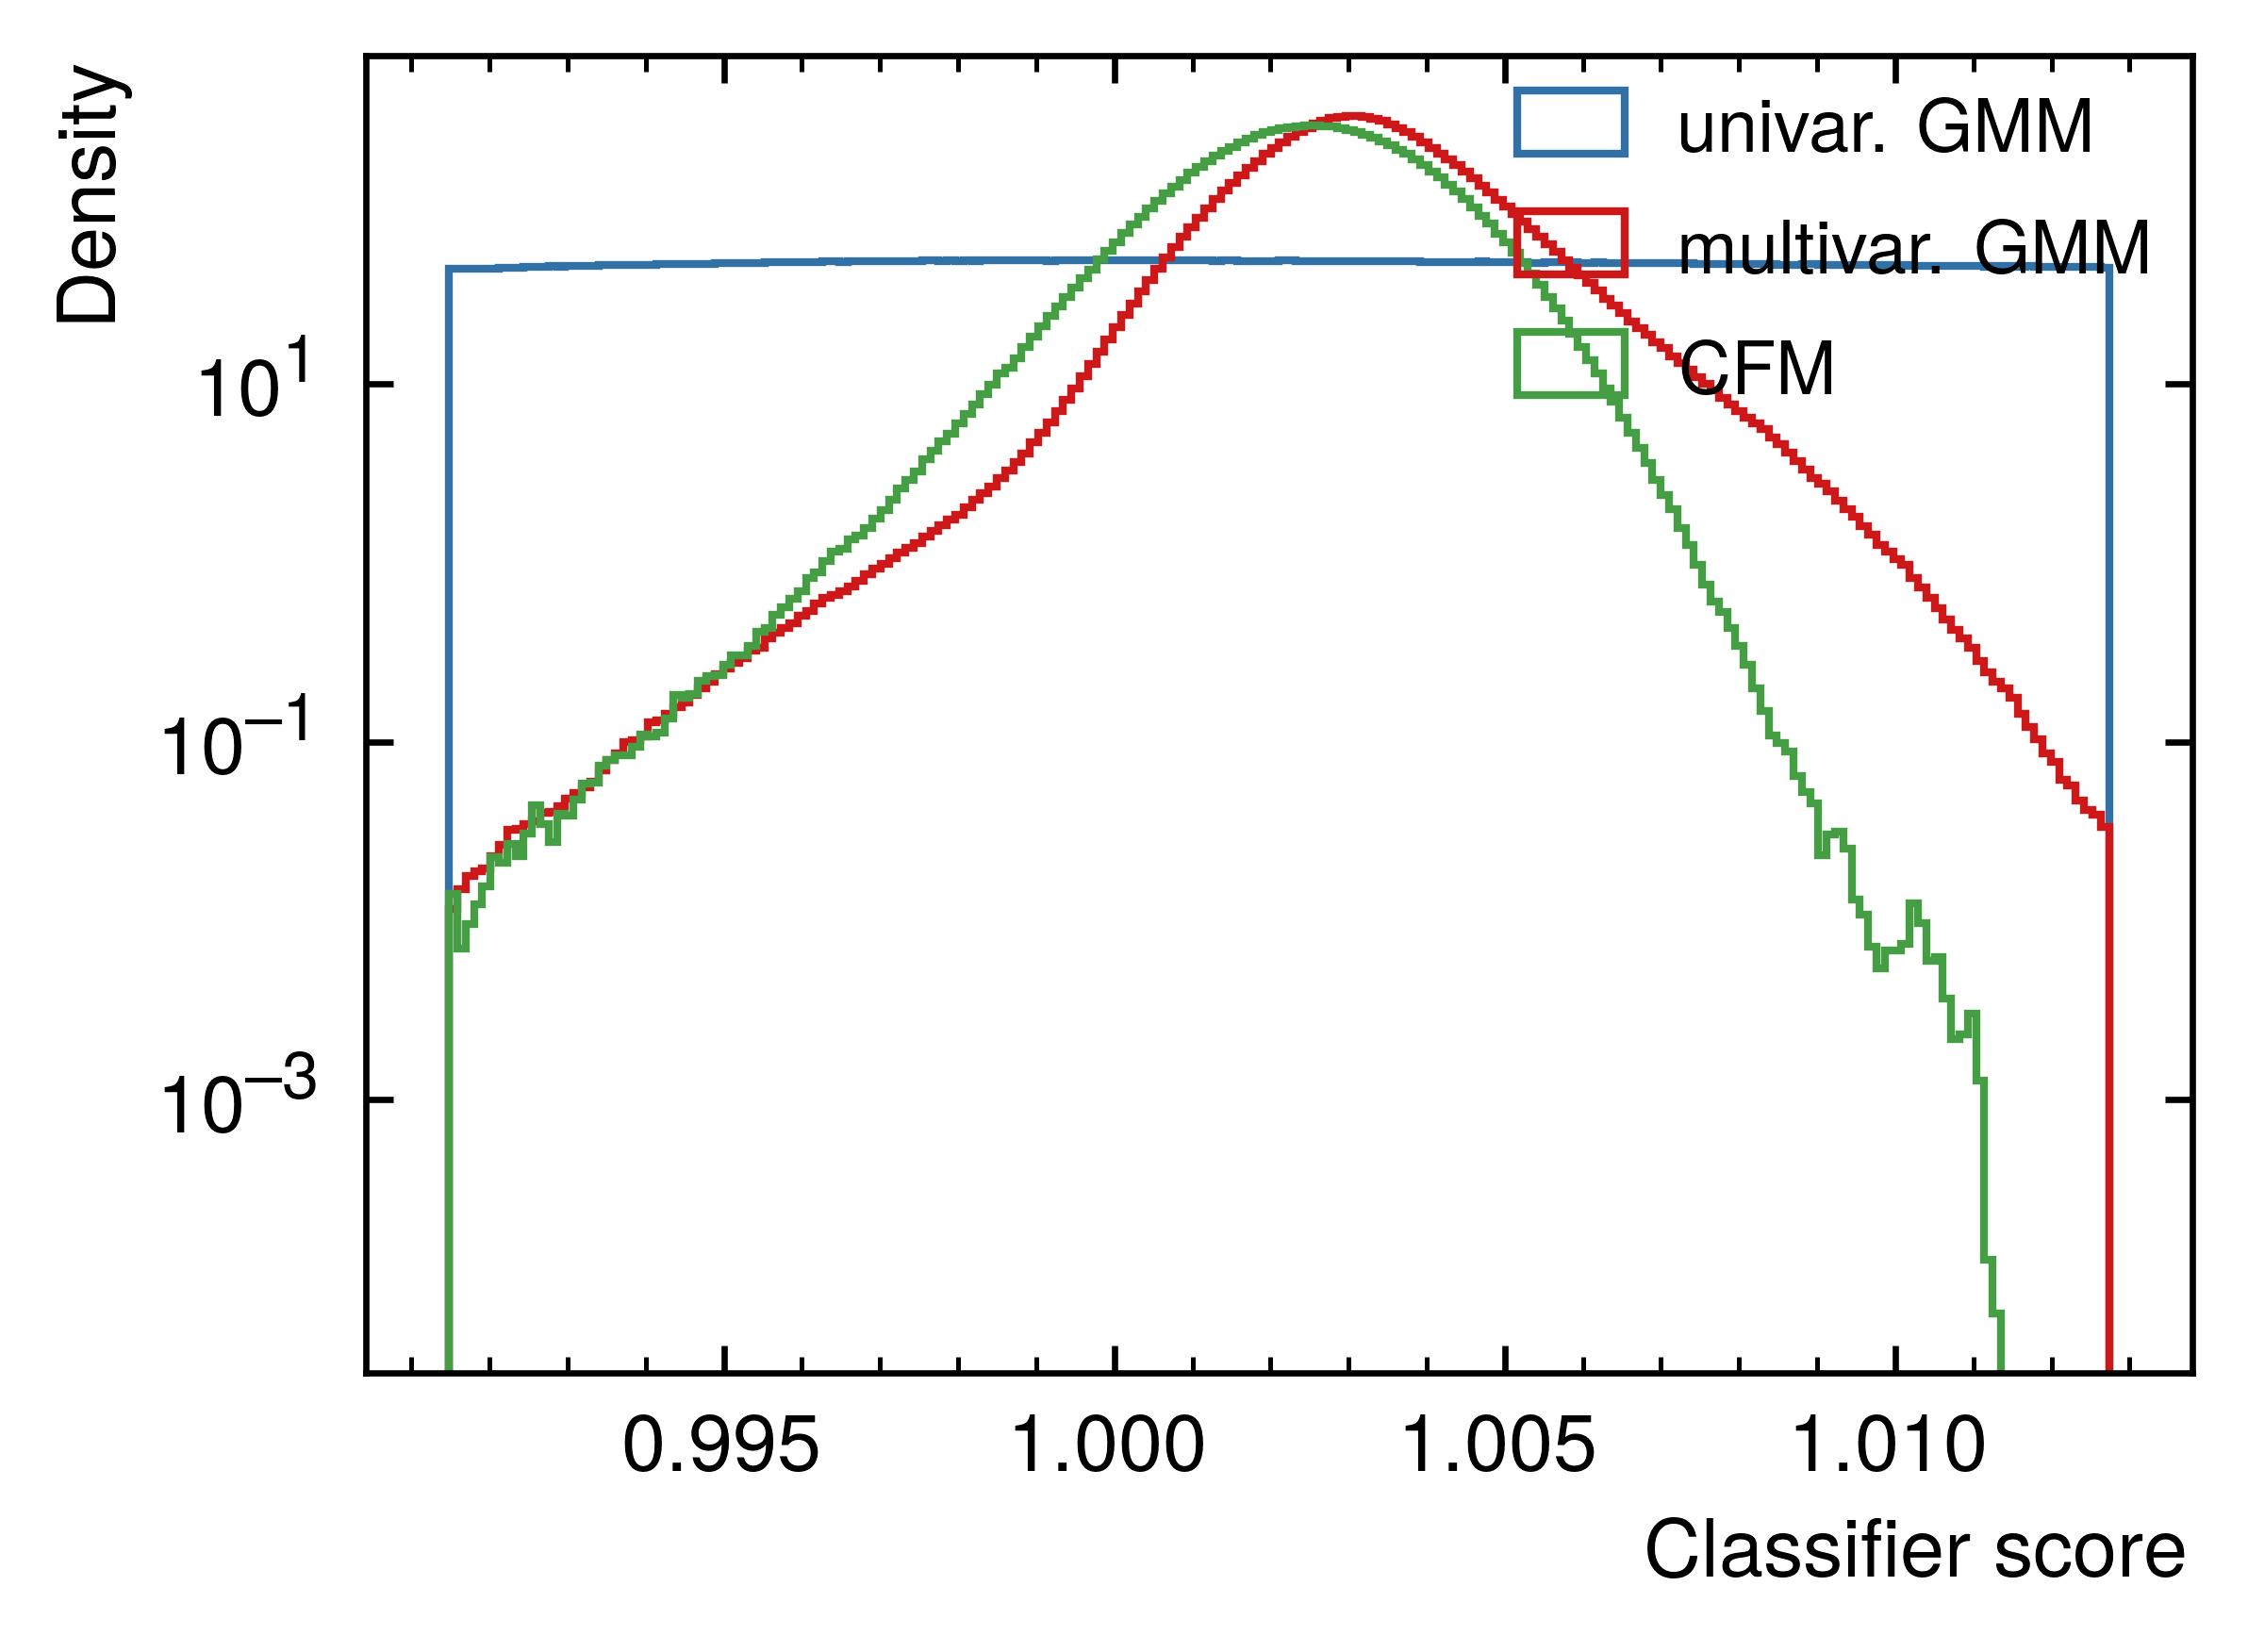

: 

In [ ]:
class_weights = []
for weight in weights:
    classes = weight["class"]
    scores = weight["weight"][classes == 0]
    class_weights.append(scores / (1. - scores + 1.e-10))

pred_range = compute_range([class_weights[1:]], quantile=0.00001)

with PdfPages(os.path.join("/remote/gpu03/schiller/JetCalibration/results/compare_runs", "classifier_weights.pdf")) as pdf:
        nbins = 200
        fig1, ax = plt.subplots(figsize=figs_hist1d)
        for class_weight, label in zip(class_weights, network_names):
                ax.hist(class_weight, bins=nbins, range=pred_range, density=True, histtype='step', label=label)
        ax.legend()
        ax.set_xlabel("Classifier score")
        ax.set_ylabel('Density')

        plt.tight_layout()
        pdf.savefig(fig1)

        nbins = 200
        fig2, ax = plt.subplots(figsize=figs_hist1d)
        for class_weight, label in zip(class_weights, network_names):
                ax.hist(class_weight, bins=nbins, range=pred_range, density=True, histtype='step', label=label)
        ax.legend()
        ax.set_xlabel("Classifier score")
        ax.set_ylabel('Density')
        ax.set_yscale('log')

        plt.tight_layout()
        pdf.savefig(fig2)

        plt.show()

        plt.close(fig1)
        plt.close(fig2)

In [7]:
wops_weights_paths = [os.path.join(path, "classifier", "Jet_MC_NoPhaseSpace", "weights.pt") for path in paths]

wops_weights = []
for weights_path in wops_weights_paths:
    wops_weights.append(torch.load(weights_path, map_location="cpu", weights_only=True))
    print(f"File {weights_path} loaded")

File /remote/gpu03/schiller/JetCalibration/results/20250707_144305_GMM_test4/classifier/Jet_MC_NoPhaseSpace/weights.pt loaded
File /remote/gpu03/schiller/JetCalibration/results/20250716_225717_Multivariate_GMM2/classifier/Jet_MC_NoPhaseSpace/weights.pt loaded
File /remote/gpu03/schiller/JetCalibration/results/20250709_165533_CFM3/classifier/Jet_MC_NoPhaseSpace/weights.pt loaded


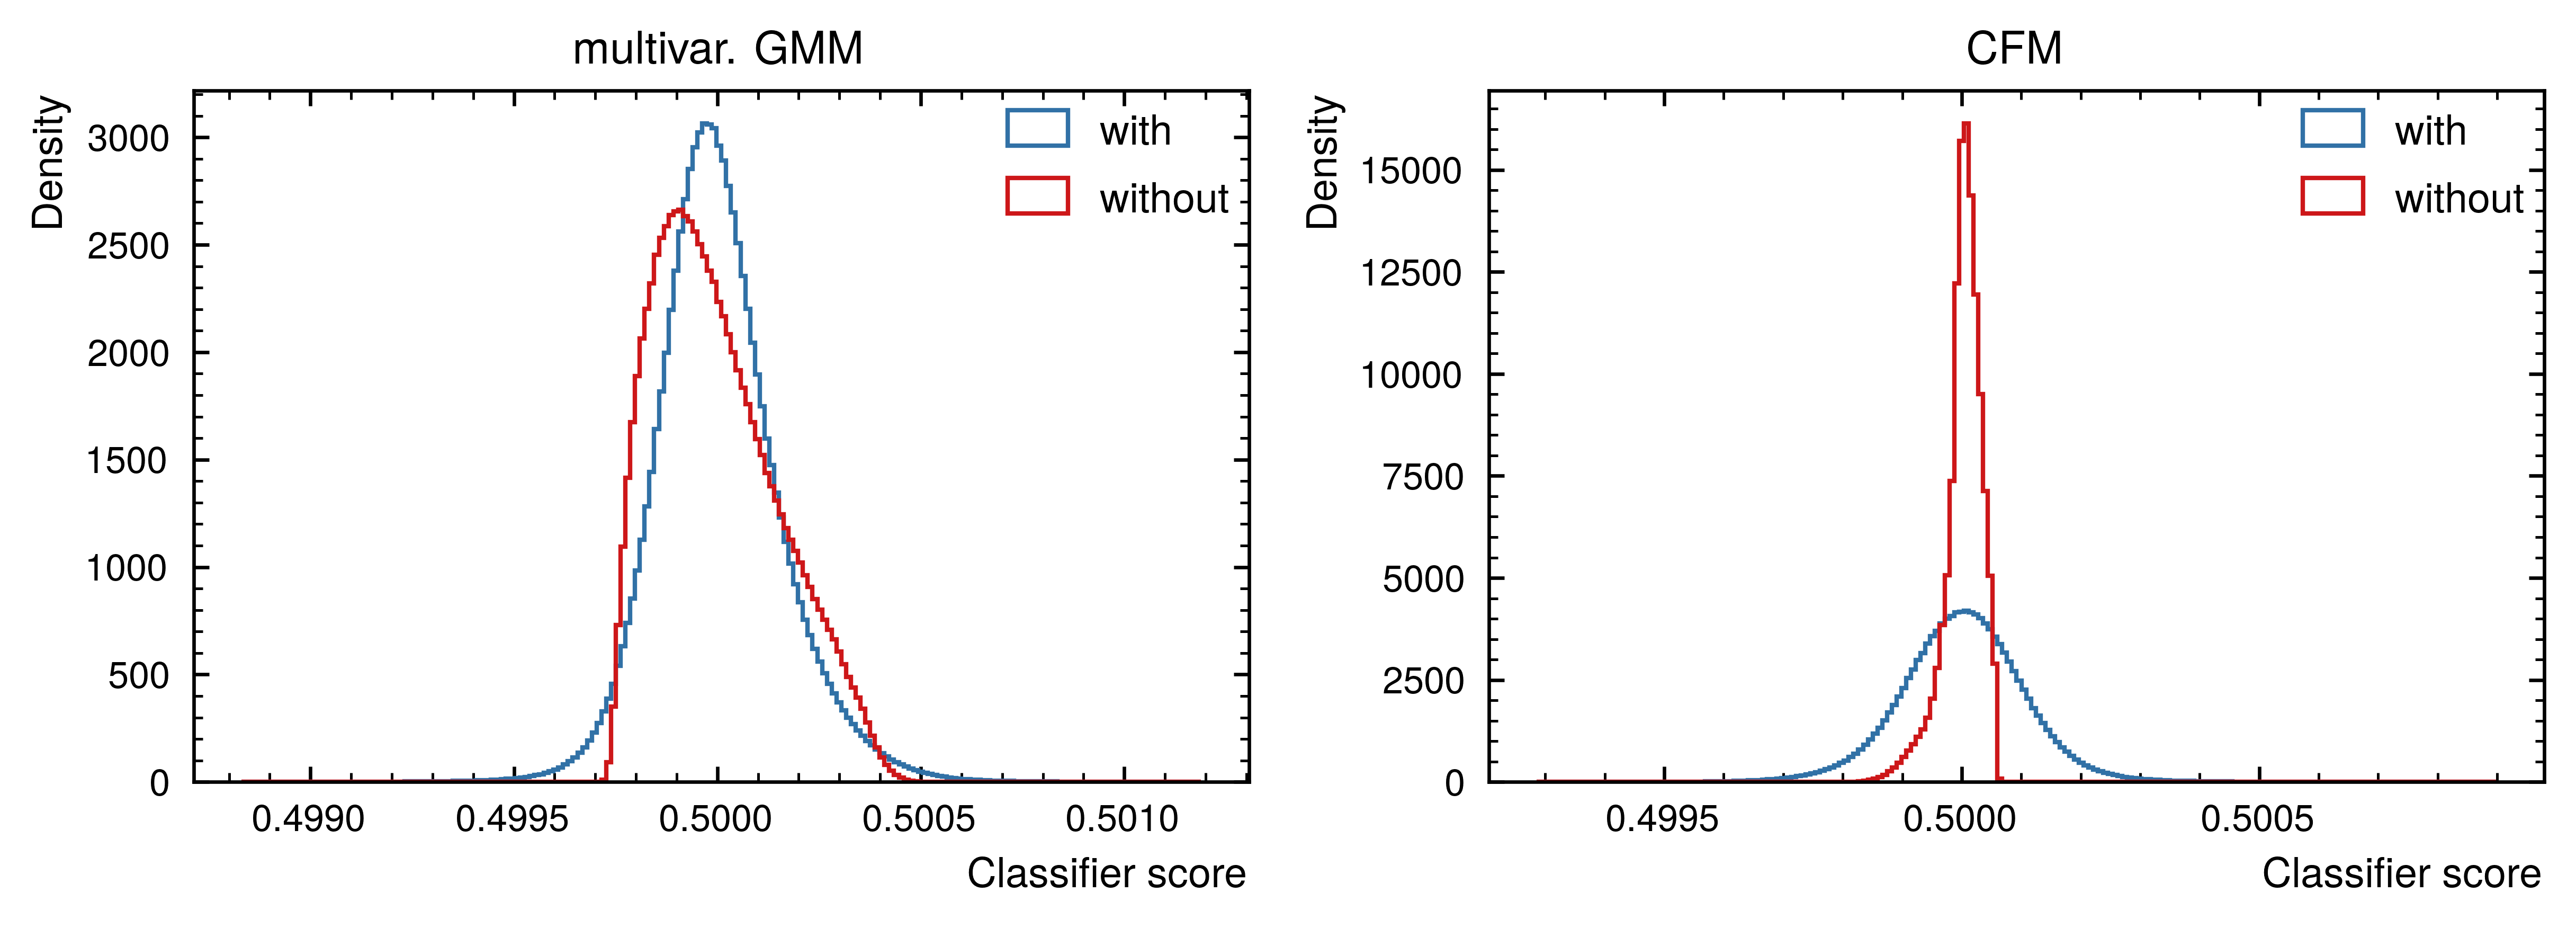

In [8]:
with PdfPages(os.path.join("/remote/gpu03/schiller/JetCalibration/results/compare_runs", "classifier_scores_phasespace_dependent.pdf")) as pdf:
        nbins = 200

        fig1, axs = plt.subplots(1, 2, figsize=figs_hist_twice)

        pred_range = compute_range([weights[1]["weight"], wops_weights[1]["weight"]], quantile=0.00001)
        
        classes_ps = weights[1]["class"]
        scores_ps = weights[1]["weight"][classes == 0]
        axs[0].hist(scores_ps, bins=nbins, range=pred_range, density=True, histtype='step', label="with")

        classes_wops = wops_weights[1]["class"]
        scores_wops = wops_weights[1]["weight"][classes == 0]
        axs[0].hist(scores_wops, bins=nbins, range=pred_range, density=True, histtype='step', label="without")
        
        axs[0].set_xlabel("Classifier score", fontsize=11)
        axs[0].set_ylabel('Density', fontsize=11)
        axs[0].tick_params(axis='both', which='major', labelsize=10)
        axs[0].legend()
        axs[0].set_title(network_names[1])

        pred_range = compute_range([weights[2]["weight"], wops_weights[2]["weight"]], quantile=0.00001)
        
        classes_ps = weights[2]["class"]
        scores_ps = weights[2]["weight"][classes == 0]
        axs[1].hist(scores_ps, bins=nbins, range=pred_range, density=True, histtype='step', label="with")

        classes_wops = wops_weights[2]["class"]
        scores_wops = wops_weights[2]["weight"][classes == 0]
        axs[1].hist(scores_wops, bins=nbins, range=pred_range, density=True, histtype='step', label="without")
        
        axs[1].set_xlabel("Classifier score", fontsize=11)
        axs[1].set_ylabel('Density', fontsize=11)
        axs[1].tick_params(axis='both', which='major', labelsize=10)
        axs[1].legend()
        axs[1].set_title(network_names[2])

        plt.tight_layout()
        pdf.savefig(fig1)

        plt.show()

        plt.close(fig1)

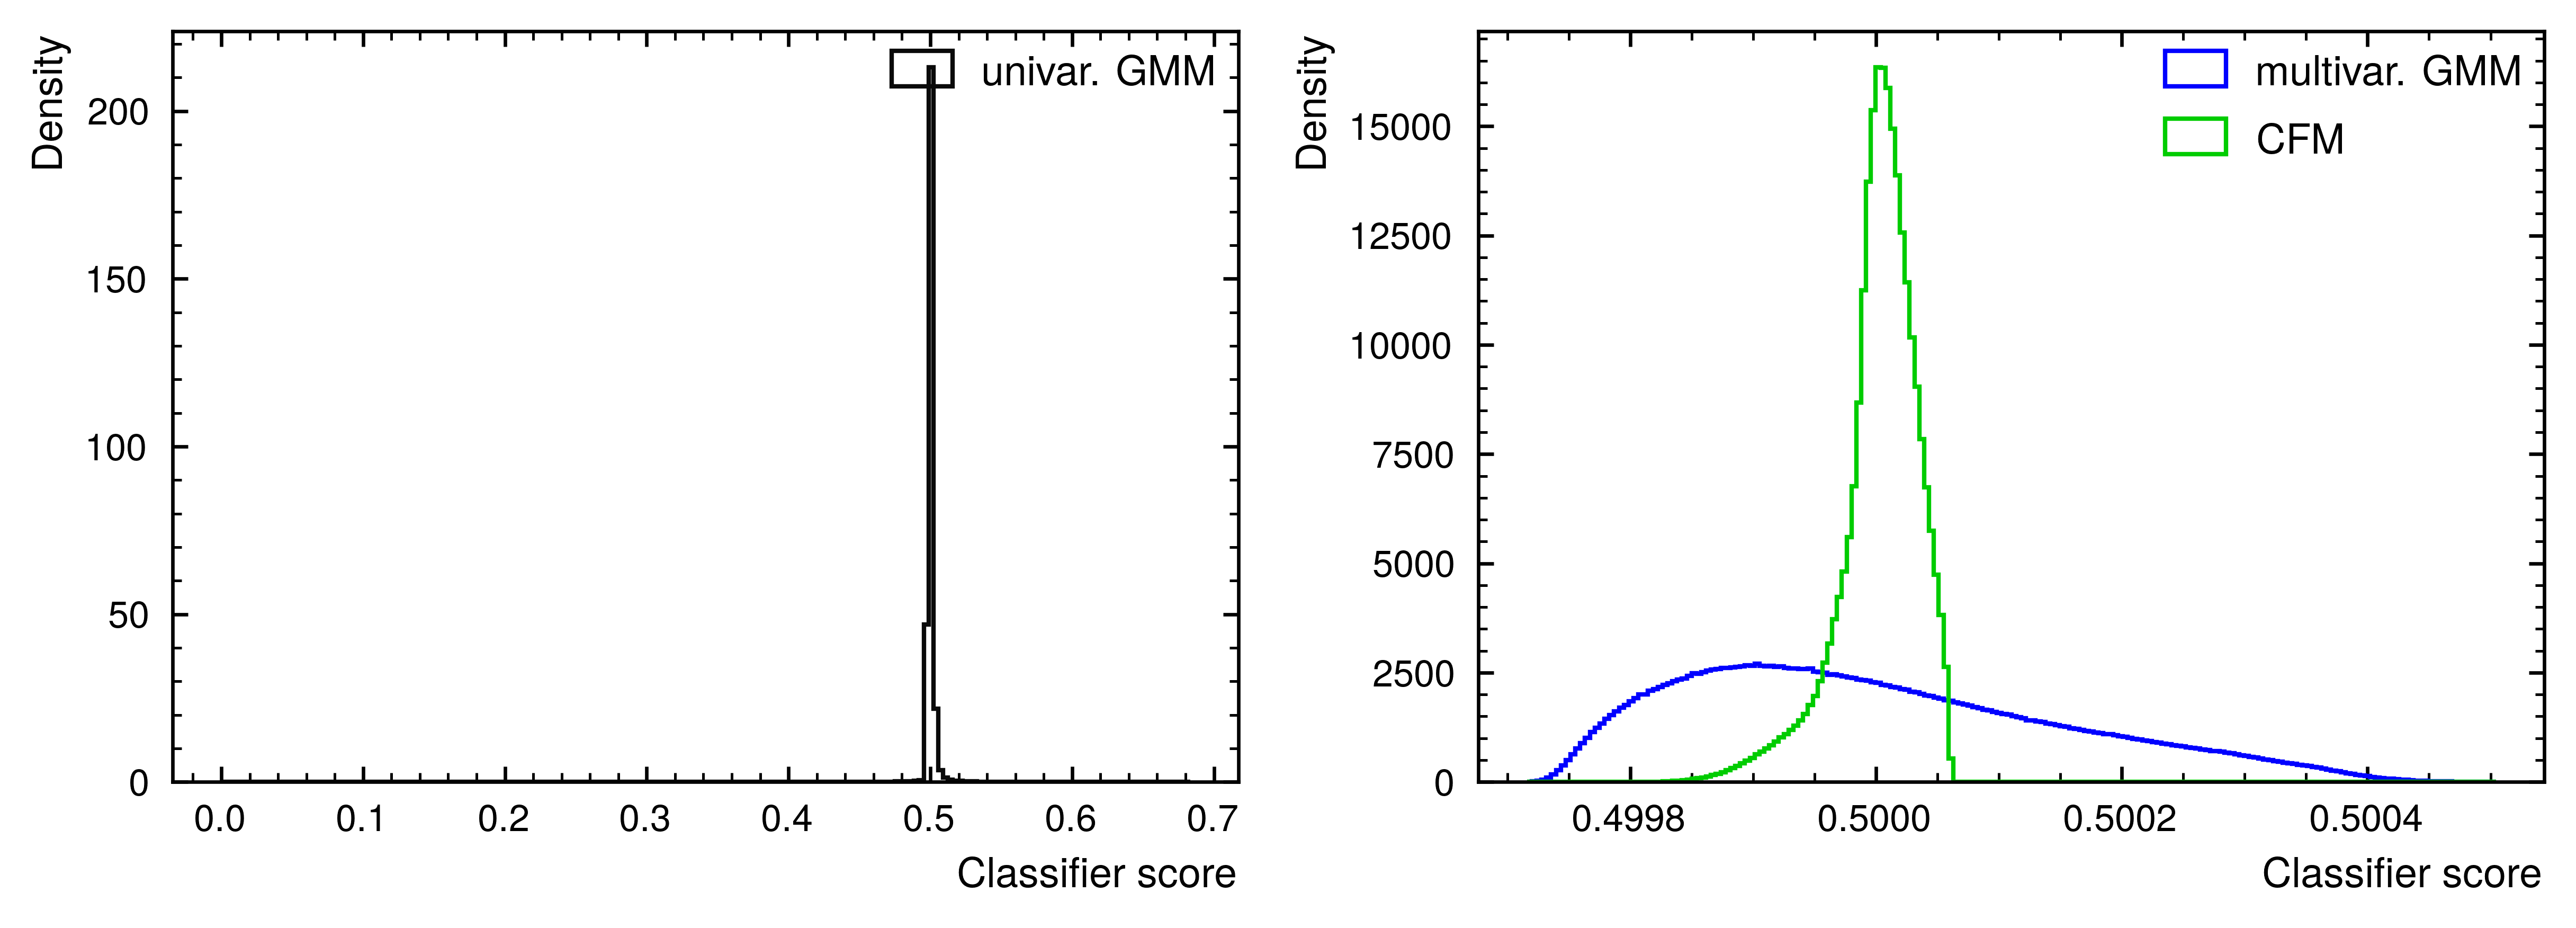

In [10]:
with PdfPages(os.path.join("/remote/gpu03/schiller/JetCalibration/results/compare_runs", "classifier_scores_wo_phasespace.pdf")) as pdf:
        legend_objs = []
        legend_labels = []

        nbins = 200

        # pred_range = compute_range([weight["weight"] for weight in weights], quantile=0.00001)
        pred_range = compute_range([weight["weight"] for weight in wops_weights[:1]], quantile=0.00001)

        fig1, axs = plt.subplots(1, 2, figsize=figs_hist_twice)
        for i, (weight, label, color) in enumerate(zip(wops_weights[:1], network_names[:1], colors[:1])):
                classes = weight["class"]
                scores = weight["weight"][classes == 0]
                _, _, h = axs[0].hist(scores, bins=nbins, range=pred_range, density=True, histtype='step', color=color)
                
                legend_objs.append(h[0])
                legend_labels.append(label)
        axs[0].set_xlabel("Classifier score", fontsize=11)
        axs[0].set_ylabel('Density', fontsize=11)
        # axs[0].set_yscale('log')
        axs[0].tick_params(axis='both', which='major', labelsize=10)
        
        pred_range = compute_range([weight["weight"] for weight in wops_weights[1:]], quantile=0.00001)

        for weight, label, color in zip(wops_weights[1:], network_names[1:], colors[1:]):
                classes = weight["class"]
                scores = weight["weight"][classes == 0]
                _, _, h = axs[1].hist(scores, bins=nbins, range=pred_range, density=True, histtype='step', color=color)

                legend_objs.append(h[0])
                legend_labels.append(label)
        axs[1].set_xlabel("Classifier score", fontsize=11)
        axs[1].set_ylabel('Density', fontsize=11)
        axs[1].tick_params(axis='both', which='major', labelsize=10)

        # fig1.legend(legend_objs, legend_labels, ncol=3, loc='upper left', bbox_to_anchor=(0.5, 0.95), framealpha=0.)
        # fig1.subplots_adjust(top=0.85)
        axs[0].legend(legend_objs[:1], legend_labels[:1])
        axs[1].legend(legend_objs[1:], legend_labels[1:])

        plt.tight_layout()
        pdf.savefig(fig1)

        plt.show()
        plt.close(fig1)